In [1]:
import numpy as np
import pandas as pd
import time
import warnings
from sklearn import metrics, preprocessing, tree
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("heart.csv")

In [3]:
col_names = list(df.columns)

In [4]:

def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
feature_cols = col_names[:13]

In [7]:
df.shape

(303, 14)

In [8]:

from sklearn.tree import DecisionTreeClassifier as dt
clf = dt()

In [9]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [10]:
X = df[feature_cols]
y = df.target

In [12]:
X.shape

(303, 13)

In [13]:
y.shape

(303,)

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 0)

In [15]:
X_train.shape

(212, 13)

In [16]:
X_test.shape

(91, 13)

## cross validation

In [18]:

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')

In [19]:

scores.mean()

0.7069355488211324

## cross_val_score is 0.70

In [20]:

# Fit the model
clf.fit(X_train, y_train)
# Make predictions
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

In [21]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [22]:
train_cols = df.columns[0:len(df.columns)-1]

In [23]:
target_cols = df.columns[-1]

In [25]:

print('The Training F1 Score is', f1_score(train_predictions, y_train))
print('The Testing F1 Score is', f1_score(test_predictions, y_test))

The Training F1 Score is 1.0
The Testing F1 Score is 0.7252747252747254


## as training f1 score is 1.0 (100) percent so our model is overfited over the training data but is not giving accurate results for test data,So we need to optimize it further

In [26]:
parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,None], 
              'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11,12], 
              'min_samples_split':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,],
              'criterion' : ['gini'],
              'max_features' : ['auto','sqrt','log2',2,3,4,5,6,7,8,9]}
scorer = make_scorer(f1_score)

In [27]:
@timeit
def generate_clf_from_search(grid_or_random, clf, parameters, scorer, X, y):
    if grid_or_random == "Grid":
        search_obj = GridSearchCV(clf, parameters, scoring=scorer)
    elif grid_or_random == "Random":
        search_obj = RandomizedSearchCV(clf, parameters, scoring=scorer)
    fit_obj = search_obj.fit(X, y)
    best_clf = fit_obj.best_estimator_
    return best_clf

In [28]:
best_clf_grid = generate_clf_from_search("Grid", 
                                         clf, 
                                         parameters, 
                                         scorer, 
                                         X_train, 
                                         y_train)

'generate_clf_from_search'  1268003.33 ms


In [30]:
scores = cross_val_score(best_clf_grid, X_train, y_train, cv=5, scoring='f1_macro')
scores.mean()

0.7812113336566209

In [32]:
best_clf_grid.fit(X_train, y_train)
# Make predictions using the new model.
best_train_predictions = best_clf_grid.predict(X_train)
best_test_predictions = best_clf_grid.predict(X_test)

# Calculate the f1_score of the new model.
print('The training F1 Score is', f1_score(best_train_predictions, y_train))
print('The testing F1 Score is', f1_score(best_test_predictions, y_test))

The training F1 Score is 0.8669527896995708
The testing F1 Score is 0.7499999999999999


In [33]:
best_clf_grid

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
                       max_features=7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

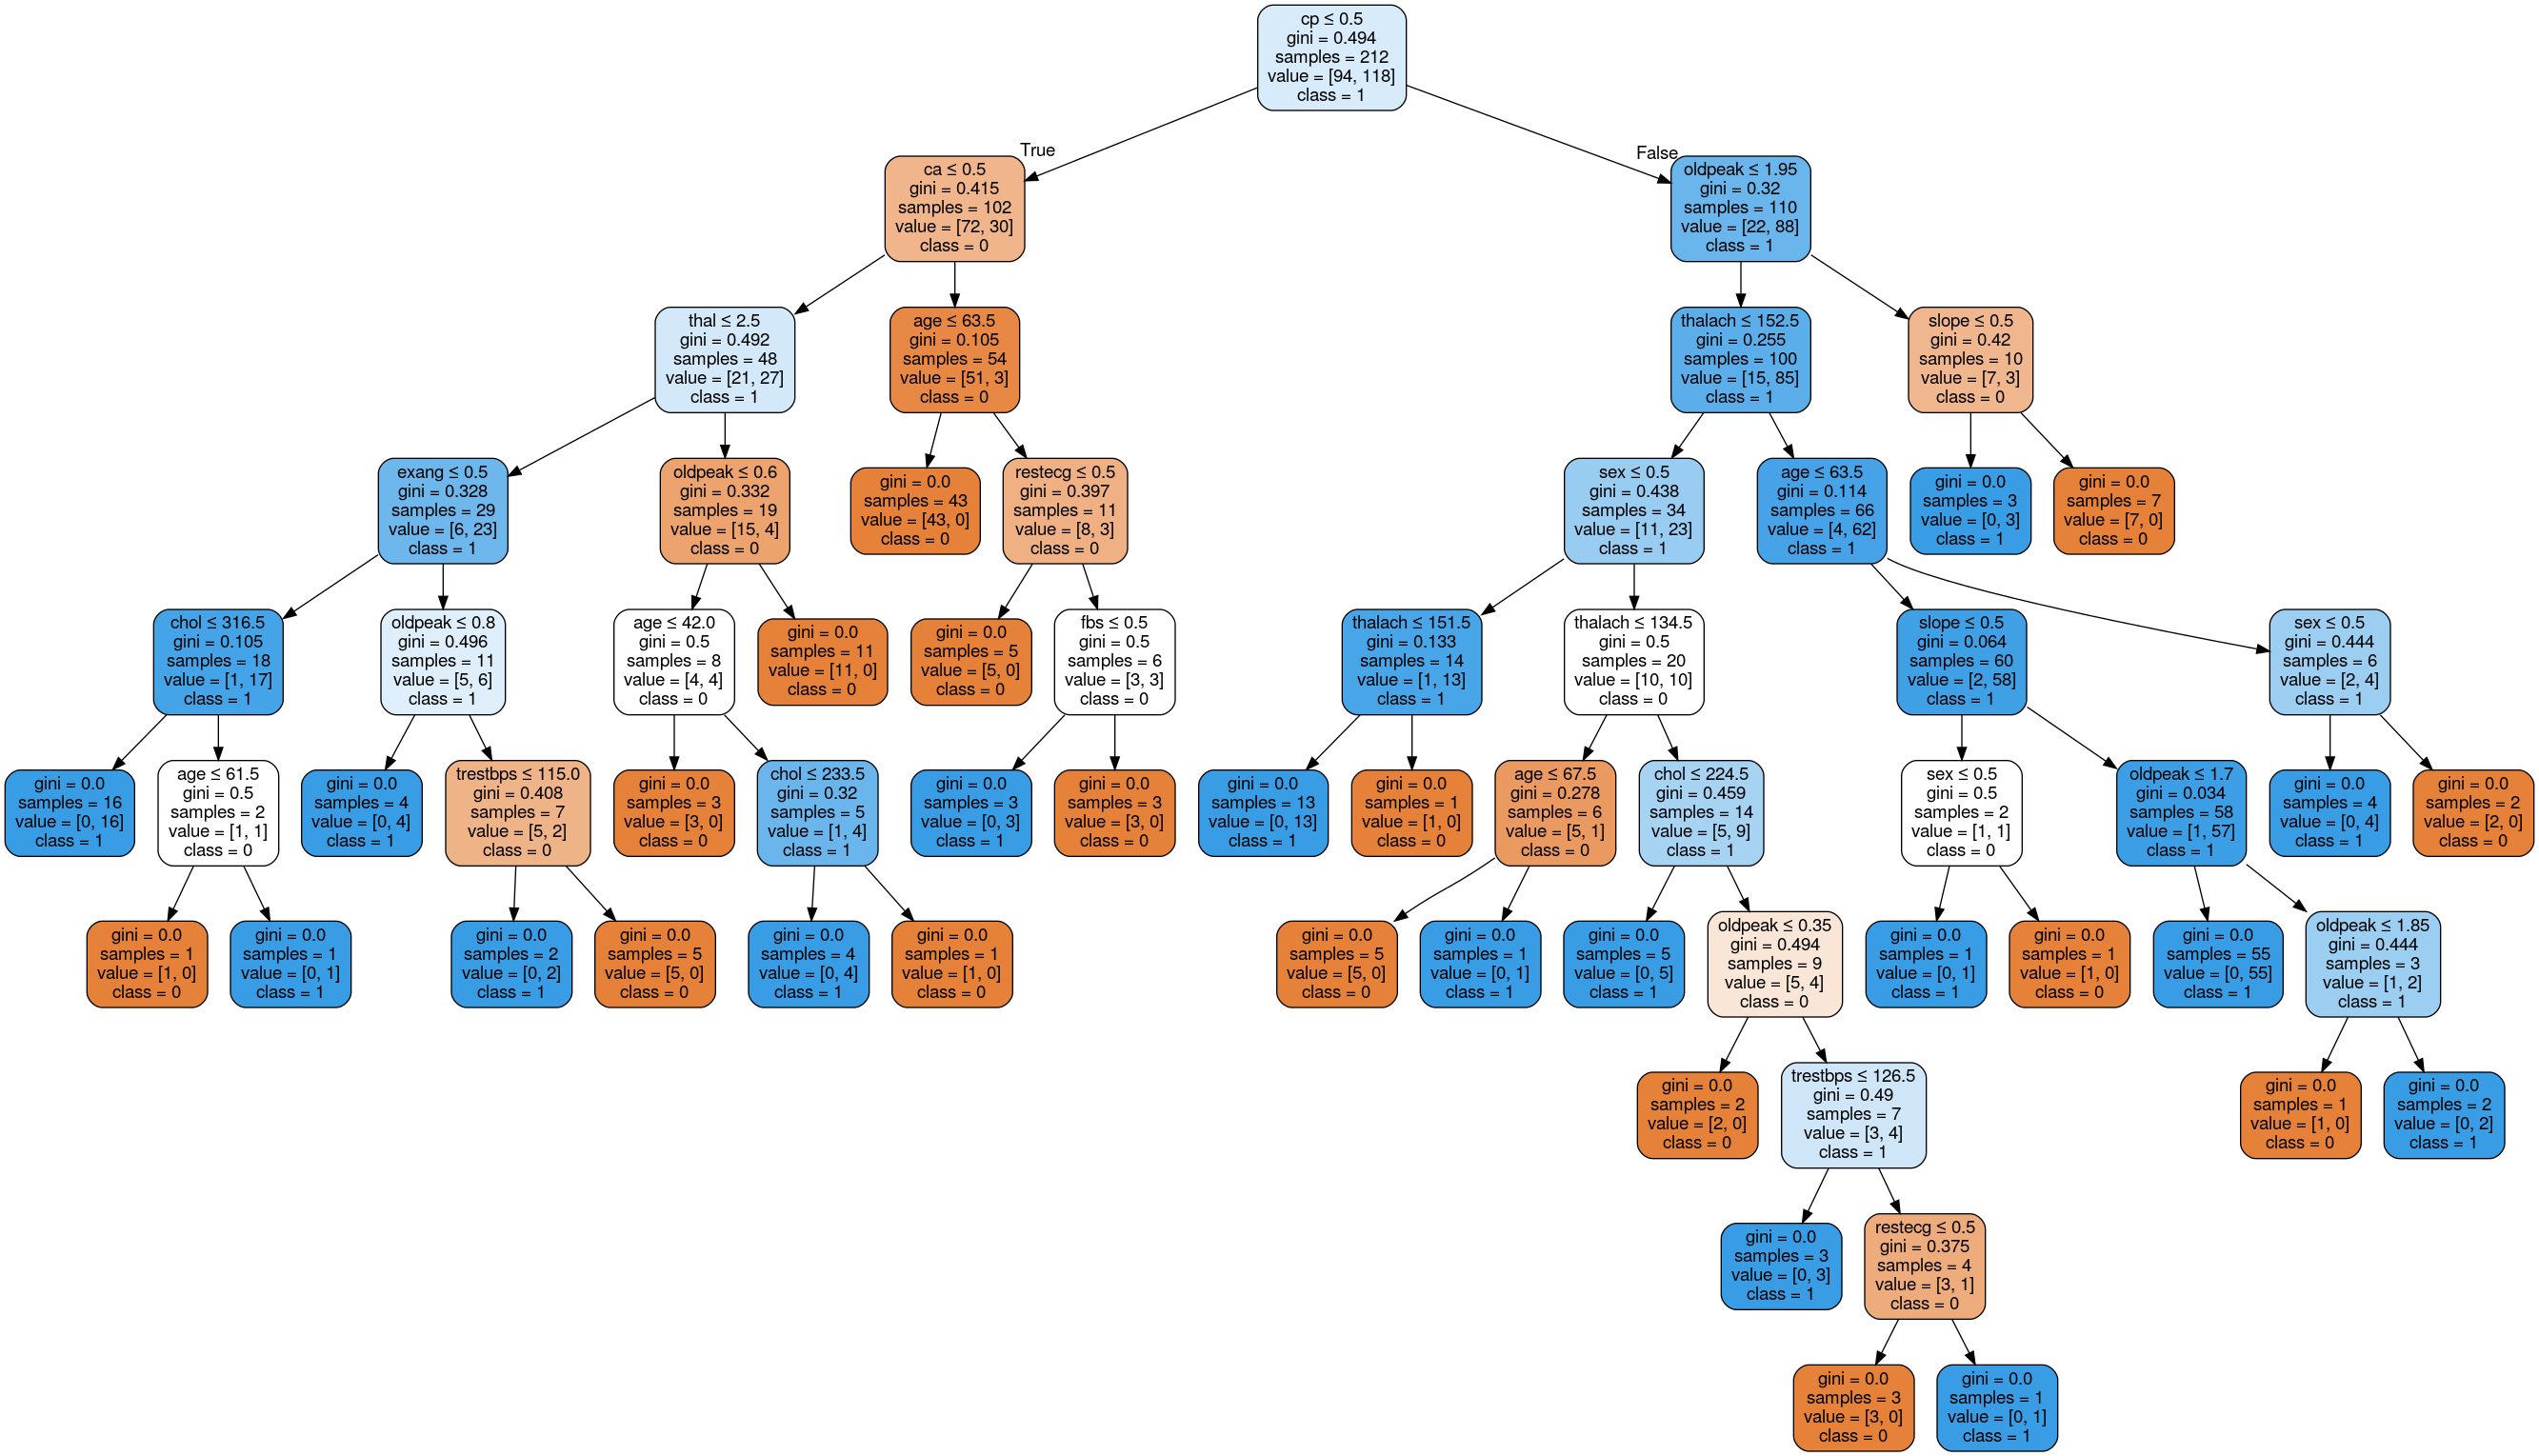

In [35]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus
dot_data = StringIO()
export_graphviz(clf,out_file = dot_data,filled = True , rounded = True , special_characters = True ,feature_names = feature_cols,class_names = ['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.write_png('heart.png')
Image(graph.create_png())

## the model is underfit we can still improve

In [36]:
feature_cols1 = ['thalach','ca','oldpeak','cp','exang','slope','thal']

In [37]:
X1 = df[feature_cols1]
y1 = df.target
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,test_size = 0.3,random_state = 0)

In [39]:

scores1 = cross_val_score(clf, X1_train, y1_train, cv=5, scoring='f1_macro')

In [42]:

scores1.mean()

0.7204893548369885

In [53]:

# Fit the model
clf.fit(X1_train, y1_train)
# Make predictions
train_predictions1 = clf.predict(X1_train)
test_predictions1 = clf.predict(X1_test)

In [54]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [55]:
train_cols1= feature_cols1

In [56]:
target_cols1 = df.columns[-1]

In [75]:

print('The Training F1 Score is', f1_score(train_predictions1, y1_train))
print('The Testing F1 Score is', f1_score(test_predictions1, y1_test))

The Training F1 Score is 1.0
The Testing F1 Score is 0.8282828282828283


In [59]:
parameters1 = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,None], 
              'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11,12], 
              'min_samples_split':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
              'criterion' : ['gini'],
              'max_features' : ['auto','sqrt','log2',2,3,4,5,6,7]}
scorer = make_scorer(f1_score)

In [82]:
best_clf_grid1 = generate_clf_from_search("Grid", 
                                         clf, 
                                         parameters1, 
                                         scorer, 
                                         X1_train, 
                                         y1_train)

'generate_clf_from_search'  566624.26 ms


In [83]:
scores1 = cross_val_score(best_clf_grid1, X1_train, y1_train, cv=5, scoring='f1_macro')
scores1.mean()

0.7909768133987819

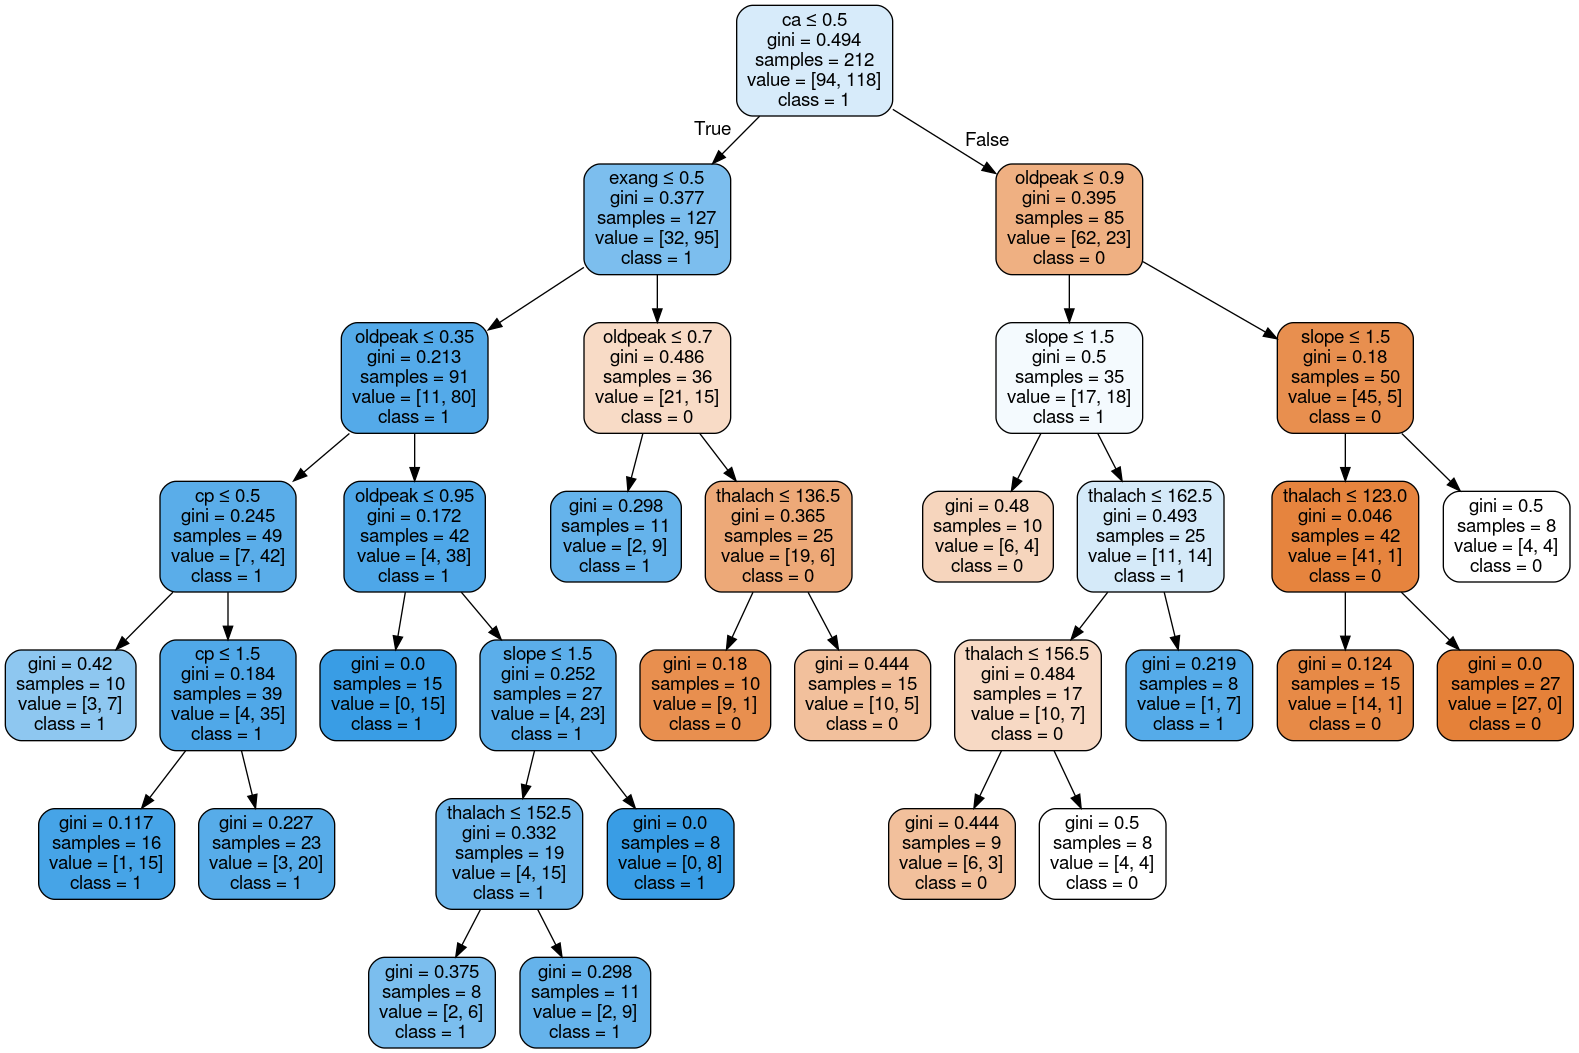

In [63]:
dot_data = StringIO()
export_graphviz(best_clf_grid,out_file = dot_data,filled = True , rounded = True , special_characters = True ,feature_names = feature_cols1,class_names = ['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.write_png('heart.png')
Image(graph.create_png())


In [64]:
feature_cols3 = ['thal', 'thalach', 'slope', 'exang', 'cp', 'oldpeak', 'ca', 'sex']

In [65]:
feature_cols4 = ['thal', 'thalach', 'slope', 'exang', 'cp', 'oldpeak', 'ca', 'sex', 'age', 'trestbps']

In [66]:
X4 = df[feature_cols4]
y4 = df.target
X4_train,X4_test,y4_train,y4_test = train_test_split(X4,y4,test_size = 0.3,random_state = 0)

In [68]:
scores4 = cross_val_score(clf, X4_train, y4_train, cv=5, scoring='f1_macro')

In [69]:
scores1.mean()

0.7351468641413922

In [70]:

# Fit the model
clf.fit(X4_train, y4_train)
# Make predictions
train_predictions4 = clf.predict(X4_train)
test_predictions4 = clf.predict(X4_test)

In [71]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [72]:
train_cols4= feature_cols4

In [73]:
target_cols4 = df.columns[-1]

In [74]:

print('The Training F1 Score is', f1_score(train_predictions4, y4_train))
print('The Testing F1 Score is', f1_score(test_predictions4, y4_test))

The Training F1 Score is 1.0
The Testing F1 Score is 0.7096774193548387


In [76]:
parameters4 = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,None], 
              'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11,12], 
              'min_samples_split':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
              'criterion' : ['gini'],
              'max_features' : ['auto','sqrt','log2',2,3,4,5,6,7,8,9,10]}
scorer4 = make_scorer(f1_score)

In [77]:
best_clf_grid = generate_clf_from_search("Grid", 
                                         clf, 
                                         parameters4, 
                                         scorer4, 
                                         X4_train, 
                                         y4_train)

'generate_clf_from_search'  682857.95 ms


In [79]:
scores1 = cross_val_score(best_clf_grid, X4_train, y4_train, cv=5, scoring='f1_macro')
scores1.mean()

0.7854500536021458

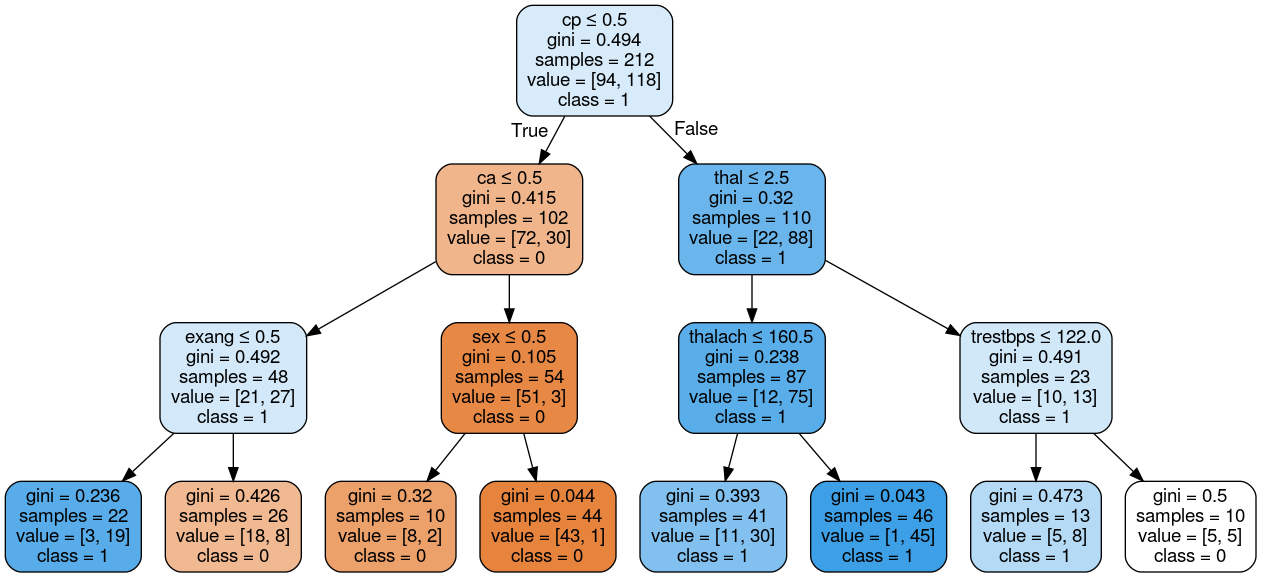

In [81]:
dot_data = StringIO()
export_graphviz(best_clf_grid,out_file = dot_data,filled = True , rounded = True , special_characters = True ,feature_names = feature_cols4,class_names = ['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.write_png('heart.png')
Image(graph.create_png())

In [84]:
X3 = df[feature_cols3]
y3 = df.target
X3_train,X3_test,y3_train,y3_test = train_test_split(X3,y3,test_size = 0.3,random_state = 0)

In [85]:
scores3 = cross_val_score(clf, X3_train, y3_train, cv=5, scoring='f1_macro')

In [86]:
scores1.mean()

0.7909768133987819

In [87]:

# Fit the model
clf.fit(X3_train, y3_train)
# Make predictions
train_predictions3 = clf.predict(X3_train)
test_predictions3 = clf.predict(X3_test)

In [88]:
print('The Training F1 Score is', f1_score(train_predictions3, y3_train))
print('The Testing F1 Score is', f1_score(test_predictions3, y3_test))

The Training F1 Score is 1.0
The Testing F1 Score is 0.7789473684210526


In [89]:
parameters3 = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,None], 
              'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11,12], 
              'min_samples_split':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
              'criterion' : ['gini'],
              'max_features' : ['auto','sqrt','log2',2,3,4,5,6,7,8]}
scorer3 = make_scorer(f1_score)

In [90]:
best_clf_grid3 = generate_clf_from_search("Grid", 
                                         clf, 
                                         parameters3, 
                                         scorer3, 
                                         X3_train, 
                                         y3_train)

'generate_clf_from_search'  564355.24 ms


In [91]:
scores3 = cross_val_score(best_clf_grid3, X3_train, y3_train, cv=5, scoring='f1_macro')
scores3.mean()

0.7773867417592699

In [92]:
best_clf_grid3

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
                       max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=17,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [94]:
y3_pred = best_clf_grid3.predict(X3_test)

In [95]:
print('The Testing F1 Score is', f1_score(y3_test, y3_pred))

The Testing F1 Score is 0.7727272727272727
